# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")

db = client['Twitter']
All_Tweets_collection = db['twitter_mdp_ex_date_proj']


In [2]:
import pandas as pd
import numpy as np
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)

# sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
#                                      allowDiskUse=True
#                                    )))

time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2020,2,1,0,0,0),
                                    '$lt': datetime.datetime(2020,2,15,0,0,0)},
            'retweeted_id': None
            })
        ))# Load the regular expression library
pd.set_option('display.max_colwidth', 0)

import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

sample_df = time_sample_df
# Remove punctuation
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text')].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))
# Remove Links
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('http.*', '', x))

sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('amp', '', x))
# Convert the titles to lowercase
#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
#sample_df['full_text_processed'].head(200)

sample_df = sample_df[sample_df['full_text_processed'] != '']
sample_df = sample_df[sample_df['full_text_processed'] != ' ']

In [3]:
date = []
for timestamp in sample_df.created_at_datetime:
    date.append(timestamp.date())
      
sample_df.loc[:, ('date')] = date
sample_df.loc[:,('month')] = sample_df.created_at_datetime.dt.strftime('%y-%m')
sample_df.loc[:,('week')] = sample_df.created_at_datetime.dt.strftime('%y-w%V')

# Features
Code von TUWien angepasst für die Anwendung auf eigene Tweets

In [4]:
sample_mdp = np.array(sample_df['full_text_processed'])

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

import pickle, gensim, numpy as np

from utilities import get_train_data, get_test_data, Tokenizer, find_subtoken

PICKLE_FOLDER_PATH = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/'

TRAIN_FILENAME = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/germeval2018.training.txt'
#mdp = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/mdp_tweets.txt'

#------------------------------
#source:
#http://www.cl.uni-heidelberg.de/english/research/downloads/resource_pages/GermanTwitterEmbeddings/GermanTwitterEmbeddings_data.shtml
MODEL_FILENAME  = "/home/lisa/Darmstadt/Master Arbeit/06_Analyse/twitter-de_d100_w5_min10.bin" # 821,8 MB
MODEL_DIMENSION = 100

In [9]:
%%time
word2vec_model  = gensim.models.KeyedVectors.load_word2vec_format(MODEL_FILENAME, binary=True)

X_train, y_train_t1, y_train_t2 = get_train_data(TRAIN_FILENAME)
X_test_mdp                      = sample_mdp

CPU times: user 9.54 s, sys: 656 ms, total: 10.2 s
Wall time: 10.2 s


### NGRAM FEATURES
 * Erstelle n-Gramme mit 3-7 Buchstaben (Funktion: char_vect)
 * Erstelle n-Gramme mit 1-3 Wörtern /Funkion: token_vect
 * Anwendung auf Training/ Test und mdp Daten

In [10]:
char_vect  = TfidfVectorizer(analyzer="char", ngram_range=(3, 7), max_df=0.01, min_df=0.0002,
                             preprocessor=Tokenizer(preserve_case=False, join=True).tokenize)

token_vect = TfidfVectorizer(analyzer="word", ngram_range=(1, 3), max_df=0.01, min_df=0.0002,
                             tokenizer=Tokenizer(preserve_case=False, use_stemmer=True).tokenize)

X_CNGR_train = char_vect.fit_transform(X_train)
X_CNGR_mdp = char_vect.transform(X_test_mdp)

X_TNGR_train = token_vect.fit_transform(X_train)
X_TNGR_mdp  = token_vect.transform(X_test_mdp)

In [11]:
pickle.dump(X_CNGR_train, open(PICKLE_FOLDER_PATH + "X_CNGR_train.p", "wb" ))
pickle.dump(X_CNGR_mdp,  open(PICKLE_FOLDER_PATH + "X_CNGR_mdp.p", "wb" ))

pickle.dump(X_TNGR_train, open(PICKLE_FOLDER_PATH + "X_TNGR_train.p", "wb" ))
pickle.dump(X_TNGR_mdp, open(PICKLE_FOLDER_PATH + "X_TNGR_mdp.p", "wb" ))

In [12]:
print(X_CNGR_mdp.shape) # (9958, 207575) (14897, 207575)

(9553, 207575)


### EMB FEATURES
* Tweets werden in Token unterteilt
* Prüfe ob die Token in einem Token im vortrainierten word2vec Model entsprechen
* Wenn nicht, teile Token in Präfix und Suffix und prüfe für diese das word2vec Model (ggf. beide in emb)
* emb enthält pro Tweet Vektoren für Token und wird normalisiert mit der Länge des Tweets + ggf extra Tokens
* X_EMB enthält die normalisierten Vektoren pro Tweet

In [13]:
def get_EMB_feats(tweets):   
    tknzr = Tokenizer(preserve_case=True)
    tweets = [tknzr.tokenize(tweet) for tweet in tweets]
    
    X_EMB = []

    for tweet in tweets:
        emb = np.zeros(MODEL_DIMENSION)
        extra_tokens = 0
        
        for token in tweet:
            try:
                emb += word2vec_model[token]
            except:
                prefix = find_subtoken(token, word2vec_model, mode='initial')
                suffix = find_subtoken(token, word2vec_model, mode='final')
                    
                if prefix != None and suffix != None:
                    emb += word2vec_model[prefix] + word2vec_model[suffix]
                    extra_tokens += 1
                elif prefix != None and suffix == None:
                    emb += word2vec_model[prefix]
                elif prefix == None and suffix != None:
                    emb += word2vec_model[suffix]           
        emb /= (len(tweet) + extra_tokens)
        X_EMB.append(emb)
        
    return normalize(X_EMB)

In [14]:
%%time
X_EMB_train = get_EMB_feats(X_train)
X_EMB_mdp  = get_EMB_feats(X_test_mdp)

CPU times: user 2.23 s, sys: 3.71 ms, total: 2.23 s
Wall time: 2.23 s


In [15]:
print(X_EMB_mdp.shape)

(9553, 100)


In [16]:
pickle.dump(X_EMB_train, open(PICKLE_FOLDER_PATH + "X_EMB_train.p", "wb" ))
pickle.dump(X_EMB_mdp,  open(PICKLE_FOLDER_PATH + "X_EMB_mdp.p", "wb" ))

### TIMP FEATURES
* Finden der wichtigen Tokens - also derer die in Tweets der angegebenen Kategorie verwendet werden
* Für diese wichtigsten Tokens werden die Features analog der EMB Features aus dem word2vec model abgeleitet
* Außerdem werden für alle Tweets analog der EMB feats abgeleitet
* Vergleiche mit der Cosine Similarity und gebe die höchsten und niedrigsten Werte pro Tweet zurück


In [17]:
def k_most_imp_tokenlvl(k, category, max_df=0.01, min_df=0.0002):      
    token_vect = TfidfVectorizer(analyzer="word", ngram_range=(1, 1), lowercase=False,
                                 max_df=max_df, min_df=min_df,
                                 tokenizer=Tokenizer(preserve_case=True).tokenize)
    
    tfidf = token_vect.fit_transform(X_train)
    
    vocab = token_vect.vocabulary_
    inv_vocab = {index: word for word, index in vocab.items()}
    
    if category in ['OTHER', 'OFFENSE']:
        cat_ids = np.where(y_train_t1 == category)
    elif category in ['PROFANITY', 'ABUSE', 'INSULT']:
        cat_ids = np.where(y_train_t2 == category)
        
    most_imp_ids = np.argsort(np.asarray(np.mean(tfidf[cat_ids], axis=0)).flatten())[::-1]
        
    most_imp = []
    for index in most_imp_ids:
        most_imp.append(inv_vocab[index])

    return most_imp[:k]

def get_TIMP_feats(tweets, k, category, max_df=0.01, min_df=0.0002):
    feats_max = []
    feats_min = []
           
    imp_tokens_vectors = []
    for imp_token in k_most_imp_tokenlvl(k, category, max_df=max_df, min_df=min_df):
        try:
            imp_tokens_vectors.append(word2vec_model[imp_token])
        except:
            imp_tokens_vectors.append(np.zeros(MODEL_DIMENSION))
    
    tknzr = Tokenizer(preserve_case=True)
    tweets = [tknzr.tokenize(tweet) for tweet in tweets]
    
    for tweet in tweets:
        tweet_vectors = []
        for token in tweet:
            try:
                tweet_vectors.append(word2vec_model[token])
            except:
                prefix = find_subtoken(token, word2vec_model, mode='initial')
                suffix = find_subtoken(token, word2vec_model, mode='final')
                 
                if prefix != None and suffix != None:
                    tweet_vectors.append(word2vec_model[prefix])
                    tweet_vectors.append(word2vec_model[suffix])
                elif prefix != None and suffix == None:
                    tweet_vectors.append(word2vec_model[prefix])
                elif prefix == None and suffix != None:
                    tweet_vectors.append(word2vec_model[suffix])
                else:
                    tweet_vectors.append(np.zeros(MODEL_DIMENSION))
                    
        similarity = cosine_similarity(np.asarray(tweet_vectors), np.asarray(imp_tokens_vectors))
        
        feats_max.append(np.amax(similarity, axis=0))
        feats_min.append(np.amin(similarity, axis=0))
        
    return np.concatenate((feats_max, feats_min), axis=1)

In [18]:
%%time
N_TIMP_TASK1 = 1250
N_TIMP_TASK2 = 170

X_TIMP_task1_train = \
np.concatenate((get_TIMP_feats(X_train, N_TIMP_TASK1, 'OTHER'),
                get_TIMP_feats(X_train, N_TIMP_TASK1, 'OFFENSE')), axis=1)


# X_TIMP_task2_train = \
# np.concatenate((get_TIMP_feats(X_train, N_TIMP_TASK2, 'OTHER'),
#                 get_TIMP_feats(X_train, N_TIMP_TASK2, 'ABUSE'),
#                 get_TIMP_feats(X_train, N_TIMP_TASK2, 'INSULT'),
#                 get_TIMP_feats(X_train, N_TIMP_TASK2, 'PROFANITY')), axis=1)

X_TIMP_task1_mdp = \
np.concatenate((get_TIMP_feats(X_test_mdp,  N_TIMP_TASK1, 'OTHER'),
                get_TIMP_feats(X_test_mdp,  N_TIMP_TASK1, 'OFFENSE')), axis=1)

# X_TIMP_task2_mdp = \
# np.concatenate((get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'OTHER'),
#                 get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'ABUSE'),
#                 get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'INSULT'),
#                 get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'PROFANITY')), axis=1)


CPU times: user 1min 30s, sys: 1.11 s, total: 1min 32s
Wall time: 48.3 s


In [20]:
print(X_TIMP_task1_mdp.shape) #(9553, 5000)

(9553, 5000)


In [21]:
pickle.dump(X_TIMP_task1_train, open(PICKLE_FOLDER_PATH + "X_TIMP_task1_train.p", "wb" ))
# pickle.dump(X_TIMP_task2_train, open(PICKLE_FOLDER_PATH + "X_TIMP_task2_train.p", "wb" ))
pickle.dump(X_TIMP_task1_mdp,  open(PICKLE_FOLDER_PATH + "X_TIMP_task1_mdp.p", "wb" ))
# pickle.dump(X_TIMP_task2_mdp,  open(PICKLE_FOLDER_PATH + "X_TIMP_task2_mdp.p", "wb" ))

### CIMP FEATURES

In [22]:
def k_most_imp_charlvl(k, category, max_df=0.01, min_df=0.0002):    
    char_vect  = TfidfVectorizer(analyzer="char", ngram_range=(3, 7), lowercase=False,
                                 max_df=max_df, min_df=min_df,
                                 preprocessor=Tokenizer(preserve_case=True, join=True).tokenize)

    tfidf = char_vect.fit_transform(X_train)
    
    vocab = char_vect.vocabulary_
    inv_vocab = {index: word for word, index in vocab.items()}
    
    if category in ['OTHER', 'OFFENSE']:
        cat_ids = np.where(y_train_t1 == category)
    elif category in ['PROFANITY', 'ABUSE', 'INSULT']:
        cat_ids = np.where(y_train_t2 == category)       
        
    most_imp_ids = np.argsort(np.asarray(np.mean(tfidf[cat_ids], axis=0)).flatten())[::-1]
        
    most_imp = []
    for index in most_imp_ids:
        most_imp.append(inv_vocab[index])

    return most_imp[:k]

def get_CIMP_feats(tweets, k, category, max_df=0.01, min_df=0.0002):
    feats = np.zeros((len(tweets), k))
    for imp_ngram_index, imp_ngram in enumerate(k_most_imp_charlvl(k, category, max_df=max_df, min_df=min_df)):
        for tweet_index, tweet in enumerate(tweets):
            if tweet.find(imp_ngram) != -1:
                feats[tweet_index][imp_ngram_index] = 1
    return feats

In [23]:
%%time
N_CIMP_TASK1 = 3200
N_CIMP_TASK2 = 370
            
X_CIMP_task1_train = \
np.concatenate((get_CIMP_feats(X_train, N_CIMP_TASK1, 'OTHER'),
                get_CIMP_feats(X_train, N_CIMP_TASK1, 'OFFENSE')), axis=1)


# X_CIMP_task2_train = \
# np.concatenate((get_CIMP_feats(X_train, N_CIMP_TASK2, 'OTHER'),
#                 get_CIMP_feats(X_train, N_CIMP_TASK2, 'ABUSE'),
#                 get_CIMP_feats(X_train, N_CIMP_TASK2, 'INSULT'),
#                 get_CIMP_feats(X_train, N_CIMP_TASK2, 'PROFANITY')), axis=1)


X_CIMP_task1_mdp = \
np.concatenate((get_CIMP_feats(X_test_mdp,  N_CIMP_TASK1, 'OTHER'),
                get_CIMP_feats(X_test_mdp,  N_CIMP_TASK1, 'OFFENSE')), axis=1)


# X_CIMP_task2_mdp = \
# np.concatenate((get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'OTHER'),
#                 get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'ABUSE'),
#                 get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'INSULT'),
#                 get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'PROFANITY')), axis=1)

CPU times: user 1min 50s, sys: 491 ms, total: 1min 51s
Wall time: 1min 51s


In [24]:
print(X_CIMP_task1_mdp.shape) #(14897, 6400)

(9553, 6400)


# Predictions

In [ ]:
# X_CNGR_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_CNGR_train.p", "rb" ))
# X_CNGR_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_CNGR_mdp.p", "rb" ))

# X_TNGR_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_TNGR_train.p", "rb" ))
# X_TNGR_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_TNGR_mdp.p", "rb" ))


# X_CIMP_task1_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task1_train.p", "rb" ))
# X_CIMP_task1_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task1_mdp.p", "rb" ))


# X_CIMP_task2_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task2_train.p", "rb" ))
# X_CIMP_task2_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task2_mdp.p", "rb" ))


# X_TIMP_task1_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task1_train.p", "rb" ))
# X_TIMP_task1_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task1_mdp.p", "rb" ))


# X_TIMP_task2_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task2_train.p", "rb" ))
# X_TIMP_task2_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task2_mdp.p", "rb" ))


# X_EMB_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_EMB_train.p", "rb" ))
# X_EMB_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_EMB_mdp.p", "rb" ))

In [25]:
_, y1, y2 = get_train_data(TRAIN_FILENAME)

#### Funktion für das Aufteilen in Train und Test Sample 
-> StratifiedKFold sorgt dafür, dass das prozentuale Verhältnis der Klassen im jeweiligen Sample (Test, Train) gleich ist

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict, StratifiedKFold

def get_META_feats(clf, X_train, mdp, y, seeds=[42]):
    feats_train = []
    for seed in seeds:
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        feats_train.append(cross_val_predict(clf, X_train, y=y, method='predict_proba', cv=skf, n_jobs=-1))
    feats_train = np.mean(feats_train, axis=0)
    print(len(feats_train))
    print(clf)
    clf.fit(X_train, y)
    feats_mdp = clf.predict_proba(mdp)
    print(len(feats_mdp))
    
    return feats_train, feats_mdp

## TASK 1 - Base level predictions
Die drei verschiedenen Classifier (clfs_task1) werden auf die Feature Vectoren (base_feats_task1) angewandt.
Von einer 10-fold CrossVal wird für den Trainings Feature Satz der Durchschnitt genommen (jeder Spalte).
Bei den Test-/mdp Daten wird keine Cross Val durchgeführt (keine y Variablen) sondern nur mit jedem Classifier eine prediction anhand der Feature Vektoren gemacht

In [27]:
%%time
clfs_task1 = [LogisticRegression(class_weight='balanced'),
              ExtraTreesClassifier(n_estimators=100, criterion='entropy', n_jobs=-1),
              ExtraTreesClassifier(n_estimators=100, criterion='gini', n_jobs=-1)]

base_feats_task1 = [(X_CIMP_task1_train, X_CIMP_task1_mdp),
                    (X_TIMP_task1_train, X_TIMP_task1_mdp),
                    (X_CNGR_train, X_CNGR_mdp),
                    (X_TNGR_train, X_TNGR_mdp),
                    (X_EMB_train, X_EMB_mdp)]
X_META_task1_train = []
#X_META_task1_test  = []
X_META_task1_mdp  = []
for X_train, mdp in base_feats_task1:                 # X-train z.B X_CIMP_task1_train, mdp z.B X_CIMP_task1_mdp
    for clf in clfs_task1:
        feats = get_META_feats(clf, X_train, mdp, y1)

        X_META_task1_train.append(feats[0])           # aus "get_META_feats: feats_train
        X_META_task1_mdp.append(feats[1])             # aus "get_META_feats: feats_mdp
        
X_META_task1_train = np.concatenate(X_META_task1_train, axis=1)
X_META_task1_mdp  = np.concatenate(X_META_task1_mdp, axis=1)

5009
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
9553
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
9553


/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
9553
5009
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


9553
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
9553
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob

/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
9553
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_scor

In [28]:
X_META_task1_mdp.shape
#X_META_task1_train.shape

(9553, 30)

In [29]:
clf_task1 = LogisticRegression(C=0.17, class_weight='balanced')
clf_task1.fit(X_META_task1_train, y1)

# clf_task2 = LogisticRegression(C=0.2, class_weight='balanced')
# clf_task2.fit(X_META_task2_train, y2)  

preds_task1 = clf_task1.predict(X_META_task1_mdp)    
# preds_task2 = clf_task2.predict(X_META_task1_mdp)

In [30]:
pd.set_option('display.max_colwidth', 0)
sample_df['predict'] = preds_task1
# data = np.array([X_test_mdp, preds_task1])
# df = pd.DataFrame({'tweets':data[0,], 'label':data[1,]})

In [31]:
sample_df[sample_df['predict'] != 'OTHER' ]

,_id,created_at,id,full_text,is_quote_status,retweet_count,lang,created_at_datetime,user_id,user_name,...,user_followers_count,user_friends_count,user_created_at,partei,user_party,full_text_processed,date,month,week,predict
1,5e954d147973ce357347ff92,Wed Feb 12 13:55:25 +0000 2020,1227592044392132608,#Altparteienstaat2020...\n... #schwuppsderJobweg.\nhttps://t.co/Xrkp0u28h1\n#LexBrandner,False,16,und,2020-02-12 13:55:25,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,Altparteienstaat2020 schwuppsderJobweg,2020-02-12,20-02,20-w07,OFFENSE
11,5e954d147973ce3573480001,Sat Feb 08 13:49:23 +0000 2020,1226140972800782336,"Da müßte (und kann endlich!) #Söder doch mal „#Haltung“ zeigen und #Merkel bitten, dem #Bundespräsident|en einen weiteren Entlassungsvorschlag zu machen!\n#csu #altparteien https://t.co/1btYhml8ba",False,12,de,2020-02-08 13:49:23,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,Da müßte und kann endlich Söder doch mal Haltung zeigen und Merkel bitten dem Bundespräsident|en einen weiteren Entlassungsvorschlag zu machencsu altparteien,2020-02-08,20-02,20-w06,OFFENSE
15,5e954d147973ce357348000a,Sat Feb 08 12:15:21 +0000 2020,1226117309389049856,"Also nach der #Altparteienlogik müßten doch jetzt sämtliche Thüringer #cdu &amp; #fdp-Landtagsabgeordneten ausgeschlossen und abgesetzt und durch #Merkel zum Mandatsverzicht genötigt werden, oder? https://t.co/yIlJH44xLU",False,10,de,2020-02-08 12:15:21,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,Also nach der Altparteienlogik müßten doch jetzt sämtliche Thüringer cdu fdp-Landtagsabgeordneten ausgeschlossen und abgesetzt und durch Merkel zum Mandatsverzicht genötigt werden oder,2020-02-08,20-02,20-w06,OFFENSE
16,5e954d147973ce357348000b,Sat Feb 08 10:57:56 +0000 2020,1226097828075917318,@TAOnline @ChristianHirte @KemmerichThL So läuft‘s in der #Merkelpartei: Nur noch die allerletzten #Hofschranzen werden übrig bleiben und die #cdu bis zur letzten Wählerstimme zugrunderichten... Die #spd läßt grüßen!\n#Altparteien,False,0,de,2020-02-08 10:57:56,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,TAOnline ChristianHirte KemmerichThL So läuft‘s in der Merkelpartei Nur noch die allerletzten Hofschranzen werden übrig bleiben und die cdu bis zur letzten Wählerstimme zugrunderichten Die spd läßt grüßenAltparteien,2020-02-08,20-02,20-w06,OFFENSE
18,5e954d147973ce3573480013,Sat Feb 08 10:18:57 +0000 2020,1226088017154183168,@DLFNachrichten @DLF @ChristianHirte So läuft‘s in der #Merkelpartei: Nur noch die allerletzten #Hofschranzen werden übrig bleiben und die #cdu bis zur letzten Wählerstimme zugrunderichten... Die #spd läßt grüßen!\n#Altparteien,False,0,de,2020-02-08 10:18:57,713361366858481664,🇩🇪Stephan Brandner🇩🇪,...,9341,676,Fri Mar 25 13:46:18 +0000 2016,"{'_id': 5ed7e2502efe72dc73343cd6, 'Name': 'StBrandner', 'Partei': 'AFD'}",AFD,DLFNachrichten DLF ChristianHirte So läuft‘s in der Merkelpartei Nur noch die allerletzten Hofschranzen werden übrig bleiben und die cdu bis zur letzten Wählerstimme zugrunderichten Die spd läßt grüßenAltparteien,2020-02-08,20-02,20-w06,OFFENSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9543,5ed783320af7ab1cc9898a04,Mon Feb 10 21:50:41 +0000 2020,1226986871454081024,"@ExSpiesser Genau, wie soll ich das meinem Kind beibringen?",False,0,de,2020-02-10 21:50:41,587862375,Canan Bayram,...,8747,2524,Tue May 22 21:58:57 +0000 2012,"{'_id': 5ed7e2502efe72dc73343d5d, 'Name': 'LieblingXhain', 'Partei': 'Gruene'}",Gruene,ExSpiesser Genau wie soll ich das meinem Kind bei

In [40]:
# pickle.dump(sample_df, open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_Wien_Feb01_20', "wb" ))
#sample_df.to_pickle('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_Wien_Feb01_20') 
#test = pickle.load(open('Sent_Wien_Feb01_20', "rb" ))

In [61]:
mdp_partei = sample_df[['user_party', 'date', 'user_screen_name', 'full_text', 'predict']]
mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['user_party'], index = ['date'], aggfunc = np.count_nonzero)

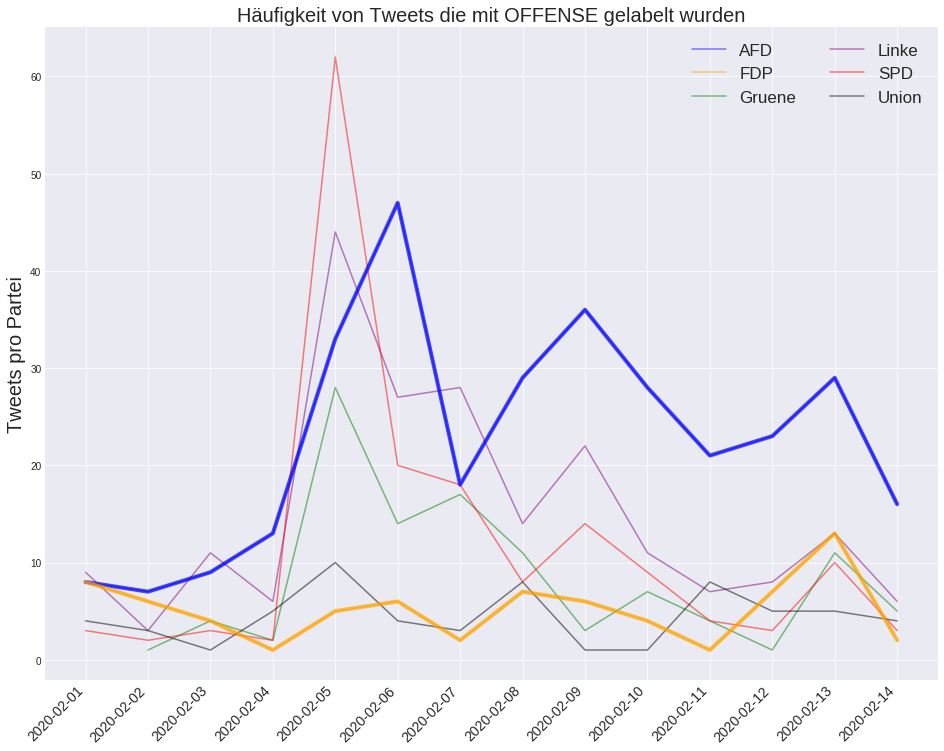

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = plt.figure(figsize = (16, 12))
ax = fig.add_subplot(111)

num=0
for column in partei_piv['full_text']:
    ax.plot(partei_piv.index, partei_piv['full_text'][column], color = my_palette[num], alpha=0.5, label = column)
    num+=1

ax.plot(partei_piv.index, partei_piv['full_text']['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)
#ax.plot(partei_piv.index, partei_piv['full_text']['SPD'], marker='', color='red', linewidth=4, alpha=0.7)
#ax.plot(partei_piv.index, partei_piv['full_text']['Linke'], marker='', color='purple', linewidth=4, alpha=0.7)
ax.plot(partei_piv.index, partei_piv['full_text']['FDP'], marker='', color='orange', linewidth=4, alpha=0.7)

ax.set_title('Häufigkeit von Tweets die mit OFFENSE gelabelt wurden', size = 20)
ylab = ax.set_ylabel('Tweets pro Partei', size = 20)
# = ax.set_xlabel('Datum', size = 20)
plt.legend(loc = 1, ncol = 2, fontsize = 17)

#x_tags
x_tags = plt.xticks(partei_piv.index, fontsize = 14, rotation = 45, ha = "right")


In [46]:
mdp_partei = sample_df[['user_party', 'week', 'user_screen_name', 'full_text', 'predict']]
mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
partei_piv['full_text']
# partei_Piv = partei_piv['full_text']
# partei_Piv.groupby('week').sum()

user_party,AFD,FDP,Gruene,Linke,SPD,Union
week,,,,,,
20-w05,15,14,1,12,5,7
20-w06,185,31,79,152,127,32
20-w07,117,27,28,45,29,23


In [ ]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.1
 
# set height of bar
bars1 = [12, 30, 1, 8, 22]
bars2 = [28, 6, 16, 5, 10]
bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['A', 'B', 'C', 'D', 'E'])
 
# Create legend & Show graphic
plt.legend()
plt.show()


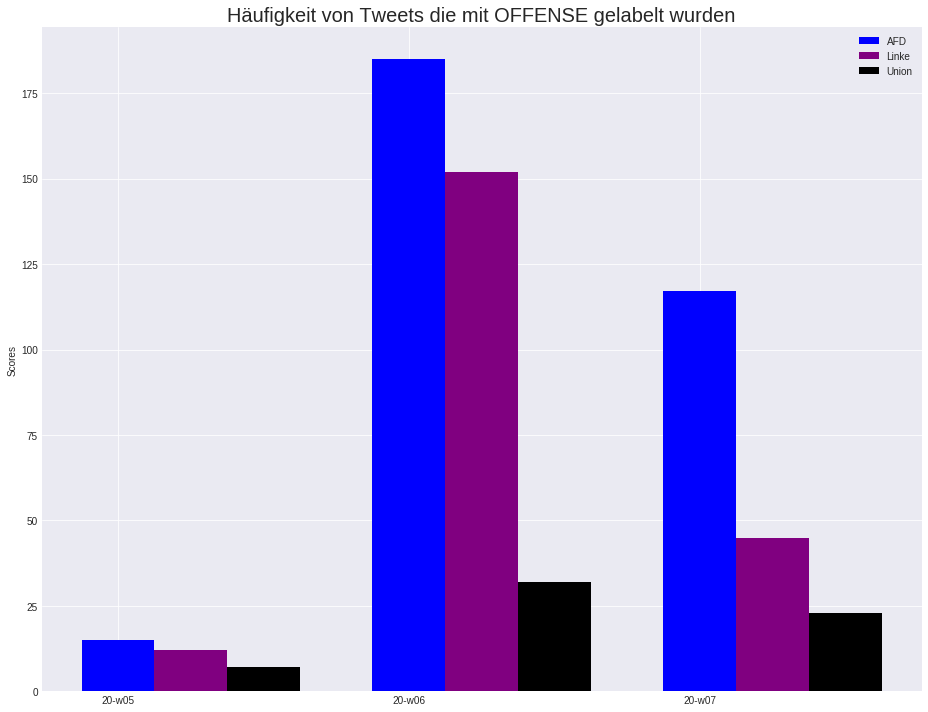

In [45]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig = plt.figure(figsize = (13, 10))
ax = fig.add_subplot(111)

r1 = np.arange(len(partei_piv['full_text'].index))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
# r4 = [x - width for x in r1]
# r5 = [x + width for x in r4]
# r6 = [x + width for x in r5]

# for column in partei_piv['full_text']:
#     ax.bar(partei_piv.index, partei_piv['full_text'][column], width, label=column)
ax.bar(r1, partei_piv['full_text']['AFD'], width, color = 'blue', label='AFD')
ax.bar(r2, partei_piv['full_text']['Linke'], width, color = 'purple', label='Linke')
ax.bar(r3, partei_piv['full_text']['Union'], width, color = 'black', label='Union')
# ax.bar(r3, partei_piv['full_text']['Gruene'], width, label='Gruene')
# ax.bar(r3, partei_piv['full_text']['Linke'], width, label='Linke')
# ax.bar(r3, partei_piv['full_text']['FDP'], width, label='FDP')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Häufigkeit von Tweets die mit OFFENSE gelabelt wurden', size = 20)
ax.set_xticks(r1)
ax.set_xticklabels(partei_piv['full_text'].index)
ax.legend()


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()

plt.show()

In [48]:
mdp_partei = sample_df[['user_party', 'month', 'user_screen_name', 'full_text', 'predict']]
# mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['predict'], index = ['user_party'], aggfunc = np.count_nonzero)
partei_piv['full_text']
# partei_Piv = partei_piv['full_text']
# partei_Piv.groupby('week').sum()

predict,OFFENSE,OTHER
user_party,,
AFD,317,962
FDP,72,1630
Gruene,108,1330
Linke,209,1427
SPD,161,1732
Union,62,1310


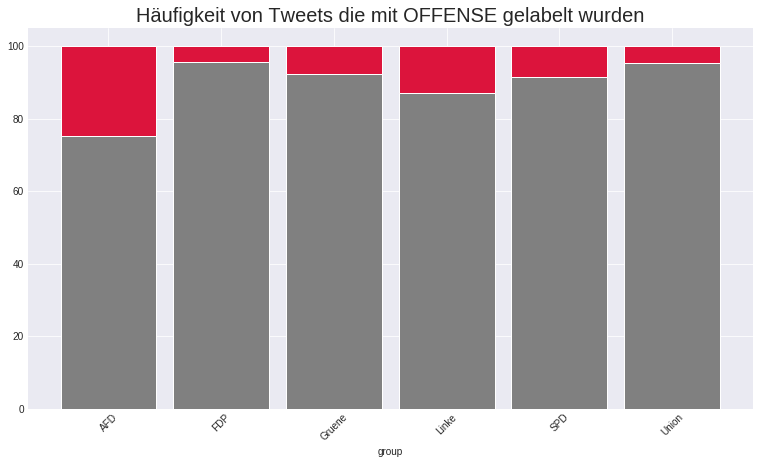

In [49]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# Data
# r = [0,1,2,3,4]
raw_data = {'greenBars': partei_piv['full_text']['OTHER'].values, 'orangeBars': partei_piv['full_text']['OFFENSE'].values}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
 
# plot
barWidth = 0.85
names = partei_piv['full_text'].index
fig = plt.figure(figsize = (13, 7))
ax = fig.add_subplot(111)

# Create green Bars
ax.bar(partei_piv['full_text'].index, greenBars, color='grey', edgecolor='white', width=barWidth)
# Create orange Bars
ax.bar(partei_piv['full_text'].index, orangeBars, bottom=greenBars, color='crimson', edgecolor='white', width=barWidth)

ax.set_title('Häufigkeit von Tweets die mit OFFENSE gelabelt wurden', size = 20)
# Custom x axis
plt.xticks(names, rotation =45)
plt.xlabel("group")
 
# Show graphic
plt.show()


In [50]:
# pd.set_option('display.max_rows', 0)
pd.set_option('display.max_rows', 500)

mdp_partei = sample_df[['user_party', 'week', 'user_screen_name', 'predict']]
# mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['predict'], index = ['user_party','user_screen_name'], aggfunc = np.count_nonzero)
partei_piv

week       
predict                     OFFENSE  OTHER
user_party user_screen_name               
AFD        AfDProtschka      12.0    36.0 
           Alice_Weidel      2.0     15.0 
           AndreasBleckMdB   7.0     11.0 
           Beatrix_vStorch   12.0    14.0 
           BerndBaumannAfD   3.0     1.0  
           Buettner_MdB     NaN      2.0  
           ChrWirthMdB      NaN      1.0  
           CorinnaMiazga    NaN      6.0  
           DirkSpaniel      NaN      3.0  
           DrFriesenMdB      2.0     14.0 
           DrHollnagel      NaN      4.0  
           DrMEspendiller    10.0    50.0 
           Dr_Rainer_Kraft   23.0    21.0 
           ElsnervonGronow   2.0     8.0  
           Frank_Pasemann    17.0    47.0 
           Frohnmaier_AfD    1.0     5.0  
           Gerold_Otten     NaN      3.0  
           GottfriedCurio    4.0     11.0 
           GtzFrmming        11.0    54.0 
           HohmannMdb       NaN      7.0  
           Jacobi_AfD        11.0    45.0 
           Jan_Nolte_AfD     1.0     16.0 
           JensMaierAfD      1.0     14.0 
           JoanaCotar        22.0    72.0 
           JuergenBraunAfD   19.0    23.0 
           KayGottschalk1   NaN      13.0 
           KestnerJens       4.0     6.0  
           Leif_Erik_Holm    4.0     7.0  
           M_HarderKuehnel  NaN      3.0  
           M_Reichardt_AfD   18.0    39.0 
           MalsackWinkeman   1.0     7.0  
           Marc_Jongen       2.0    NaN   
           Marcus_Buehl     NaN      11.0 
           Martin_Hess_AfD   3.0     12.0 
           Martin_Sichert    12.0    15.0 
           MdB_Lucassen      1.0     4.0  
           MdB_Mueller_AfD   1.0     1.0  
           NKleinwaechter    1.0     7.0  
           PeterBoehringer  NaN      4.0  
           PeterFelser       1.0     2.0  
           Pohl_MdB          1.0     5.0  
           R_Hartwig_AfD    NaN      14.0 
           Rene_Springer    NaN      3.0  
           Renner_AfD        2.0     1.0  
           S_Muenzenmaier    7.0     12.0 
           Schneider_AfD     6.0     20.0 
           StBrandner        52.0    158.0
           SteffenKotre     NaN      1.0  
           Th_Seitz_AfD     NaN      1.0  
           Thomas_Ehrhorn   NaN      1.0  
           Tino_Chrupalla    5.0     17.0 
           TobiasMPeterka    3.0     4.0  
           UdoHemmelgarn     14.0    52.0 
           Uwe_Schulz_AfD    2.0    NaN   
           Witt_Uwe          1.0    NaN   
           WolfgangWiehle    4.0     12.0 
           h_weyel          NaN      7.0  
           mrosek1958        9.0     31.0 
           ulschzi           3.0     9.0  
FDP        AKulitz          NaN      2.0  
           BraFDP           NaN      27.0 
           Bubendorferfdp   NaN      8.0  
           Chr_Sauter        1.0     4.0  
           ChristophFDP     NaN      25.0 
           DFoest            4.0     39.0 
           DanielaKluckert   1.0     21.0 
           DjirSarai        NaN      9.0  
           EUTheurer         1.0     4.0  
           G_UllrichFDP      1.0     7.0  
           GeroHocker        1.0     22.0 
           GydeJ             4.0     19.0 
           HartmutEbbing     1.0     5.0  
           HerbrandMarkus   NaN      5.0  
           HoffmannForest   NaN      36.0 
           HoubenReinhard   NaN      1.0  
           JBrandenburgFDP   5.0     38.0 
           JudithSkudelny   NaN      3.0  
           KatjaSuding       1.0     9.0  
           KatrinHelling    NaN      11.0 
           KonstantinKuhle   3.0     38.0 
           Lambsdorff        2.0     38.0 
           LindaTeuteberg   NaN      2.0  
           MAStrackZi        2.0     47.0 
           MTodtenhausen     1.0     1.0  
           ManuelHoeferlin   1.0     15.0 
           MarcoBuschmann    3.0     338.0
           MarcusFaber      NaN      14.0 
           MdBKlein         NaN      8.0  
           NicoleWestig     NaN      3.0  
           OlliLuksic        11.0    145.0
           Otto_Fricke       2.0

In [59]:
sample_df[sample_df['user_screen_name'] == 'StBrandner']
#sample_df[sample_df['date'] == datetime.date(2020,2,5)]
#sample_df.loc[:,('month')] = sample_df.created_at_datetime.dt.strftime('%y-%m')
sample_df.loc[(sample_df['date'] == datetime.date(2020,2,5)) & (sample_df['user_party'] == 'SPD')]

,_id,created_at,id,full_text,is_quote_status,retweet_count,lang,created_at_datetime,user_id,user_name,...,user_followers_count,user_friends_count,user_created_at,partei,user_party,full_text_processed,date,month,week,predict
1725,5e95902236c17d9b398e58a1,Wed Feb 05 14:27:34 +0000 2020,1225063420099289089,"Das dieser Tweet noch immer nicht gelöscht wurde, ist kein gutes Zeichen. https://t.co/Emxajnzfft",True,134,de,2020-02-05 14:27:34,42401449,Niels Annen 🇪🇺,...,12176,1157,Mon May 25 13:06:24 +0000 2009,"{'_id': 5ed7e2502efe72dc73343c5e, 'Name': 'NielsAnnen', 'Partei': 'SPD'}",SPD,Das dieser Tweet noch immer nicht gelöscht wurde ist kein gutes Zeichen,2020-02-05,20-02,20-w06,OTHER
1737,5e95904f36c17d9b398e75f2,Wed Feb 05 13:18:49 +0000 2020,1225046117764734977,Respekt @MAStrackZi 👍 https://t.co/5qjLC87Odc,True,3,sv,2020-02-05 13:18:49,19438957,Bärbel Bas,...,5025,2231,Sat Jan 24 09:39:46 +0000 2009,"{'_id': 5ed7e2502efe72dc73343c63, 'Name': 'baerbelbas', 'Partei': 'SPD'}",SPD,Respekt MAStrackZi 👍,2020-02-05,20-02,20-w06,OTHER
1777,5e95905b36c17d9b398e81bc,Wed Feb 05 21:50:37 +0000 2020,1225174915231420417,"Wir haben klare Worte formuliert, dass die @SPDThueringen da keinerlei Kooperationsmöglichkeiten in Thüringen sieht, mit jemandem der von der AfD gewählt wurde. Völlig klar. #Phoenixrunde #Thueringen #MPWahl",False,0,de,2020-02-05 21:50:37,2617281050,Lothar Binding,...,6655,436,Fri Jul 11 12:32:53 +0000 2014,"{'_id': 5ed7e2502efe72dc73343c64, 'Name': 'Lothar_Binding', 'Partei': 'SPD'}",SPD,Wir haben klare Worte formuliert dass die SPDThueringen da keinerlei Kooperationsmöglichkeiten in Thüringen sieht mit jemandem der von der AfD gewählt wurde Völlig klar Phoenixrunde Thueringen MPWahl,2020-02-05,20-02,20-w06,OTHER
1778,5e95905b36c17d9b398e81be,Wed Feb 05 16:47:40 +0000 2020,1225098679016620034,"Heute Abend 22:15 Uhr bin ich in der ⁦@phoenix_de⁩ Runde, rund um die aktuellen Ereignisse in #Thüringen https://t.co/TSksvZbKdH",False,1,de,2020-02-05 16:47:40,2617281050,Lothar Binding,...,6655,436,Fri Jul 11 12:32:53 +0000 2014,"{'_id': 5ed7e2502efe72dc73343c64, 'Name': 'Lothar_Binding', 'Partei': 'SPD'}",SPD,Heute Abend 2215 Uhr bin ich in der ⁦phoenix_de⁩ Runde rund um die aktuellen Ereignisse in Thüringen,2020-02-05,20-02,20-w06,OTHER
1791,5e9590a936c17d9b398eb618,Wed Feb 05 23:04:38 +0000 2020,1225193543888707584,"Oh, eine gute Nachricht. Kann ich heute echt gebrauchen. https://t.co/oge8Vi6zNV",True,0,de,2020-02-05 23:04:38,2805274855,Fritz Felgentreu,...,5261,413,Fri Sep 12 09:17:05 +0000 2014,"{'_id': 5ed7e2502efe72dc73343c6c, 'Name': 'fritzfelgentreu', 'Partei': 'SPD'}",SPD,Oh eine gute Nachricht Kann ich heute echt gebrauchen,2020-02-05,20-02,20-w06,OTHER
1792,5e9590a936c17d9b398eb61d,Wed Feb 05 20:50:32 +0000 2020,1225159798183923717,"Das ist interessant: https://t.co/qyAbcr0lh4 Als Klaus Wowereit und Peter Strieder 2001 die rot-rote Koalition in Berlin aufs Gleis stellten, waren der Kanzler und der Parteivorsitzende dagegen. Es war uns in der @spdberlin schnuppe: Wir hatten unsere eigenen Probleme zu lösen.",False,5,de,2020-02-05 20:50:32,2805274855,Fritz Felgentreu,...,5261,413,Fri Sep 12 09:17:05 +0000 2014,"{'_id': 5ed7e2502efe72dc73343c6c, 'Name': 'fritzfelgentreu', 'Partei': 'SPD'}",SPD,Das ist interessant,2020-02-05,20-02,20-w06,OTHER
1793,5e9590a936c17d9b398eb621,Wed Feb 05 13:39:17 +0000 2020,1225051267397013504,"@AnneBressem Wie? Hoffentlich ruhig und gleichmäßig. Wo? Links, wie immer. So wie bei all den anderen Thüringerinnen und Thüringern, die jetzt mehr denn je volle #Solidarität verdient haben.",False,0,de,2020-02-05 13:39:17,2805274855,Fritz Felgentreu,...,5261,413,Fri Sep 12 09:17:05 +0000 2014,"{'_id': 5ed7e2502efe72dc73343c6c, 'Name': 'fritzfelgentreu', 'Partei': 'SPD'}",SPD,AnneBressem Wie Hoffentlich ruhig und gleichmäßig Wo Links wie immer So wie bei all den anderen Thüringerinnen und Thüringern die jetzt mehr denn je volle Solidarität verdient haben,2020-02-05,20-02,20-w06,OTHER
1794,5e9590a936c17d9b3